In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.0.0'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from IPython.display import Image

%matplotlib inline

In [6]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print ("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


In [7]:
X_train, X_test, y_train, y_test = X[:300], X[300:], y[:300], y[300:]
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print (X_train.shape, y_train_oh.shape,  X_test.shape, y_test_oh.shape)

(300, 784) (300, 10) (1200, 784) (1200, 10)


## Network architectures lab


from the notes we have two architectures:
    
- **A**: Three layer network accepting a 784 element vector as input and outputing a 10-class vector
- **B**: Same as **A** but accepts an additional 2 element vector with _evenness_ information that is injected at the third layer.

This lab requires you to do two things:

**1**. Create a **C** architecture similar to **B** but where the 2 element vector is injected at the second layer. This will make the network have 41,650 parameters, distributed in the following way:
   
   

        INPUT 1 to LAYER 1:              784*50 + 50 (bias) = 39250
        LAYER 1 to LAYER 2:               50*30 + 30 (bias) = 1530
        LAYER 2 + INPUT 2 to LAYER 3: (30+2)*20 + 20 (bias) = 660
        LAYER 3 to OUTPUT:                20*10 + 10 (bias) = 210
    
                                                       TOTAL 41650
                                                       
**2**. Run an experimental setup where you train different network configurations and measure the accuracy on test data. Fix the number of neurons to 50, 30 and 20 for each layer and the following combination of parameters:

- For architecture **A** (3 configurations)

    `s3_activation` $\in$ `["linear", "relu", "tanh"]`

- For architectures **B** and **C** (15 configurations for each architecture)

    `s3_activation` $\in$ `["linear", "relu", "tanh"]`
    
    `k1,k2` $\in$ `[(0,1), (-.5,2),(-.5,30), (0,15),(0,30)]`

And create a heat map showing the accuracy in test obtained for each configuration, such as the following (your results should be approximate to this):

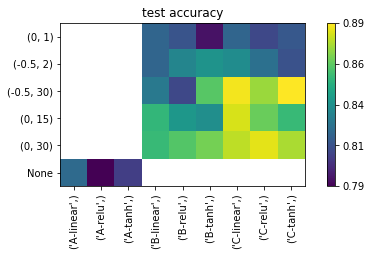

In [11]:
Image(filename='local/imgs/mm_results_1.png')

And two bar plots with the average per architecture and k1,k2 configuration, such as the following (again, your results should be approximetely similar):

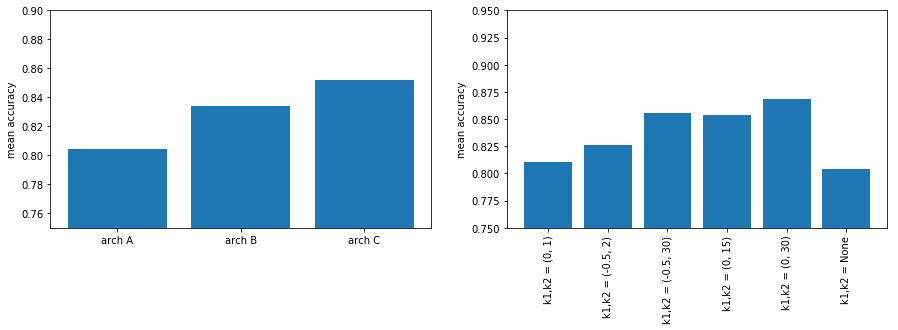

In [12]:
Image(filename='local/imgs/mm_results_2.png')

### Model definitions

In [13]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session

In [14]:
def get_model_A(input_dim, s1, s2, s3, s3_activation="relu"):
    clear_session()
    model = Sequential()
    model.add(Dense(s1, activation='relu', input_dim=input_dim))
    model.add(Dense(s2, activation='relu'))
    model.add(Dense(s3, activation=s3_activation))
    model.add(Dense(10, activation='sigmoid'))

    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [15]:
def get_model_B(input_dim, extra_info_dim,  s1, s2, s3, s3_activation="relu"):
    clear_session()
    inp1 = Input(shape=(input_dim,))
    inp2 = Input(shape=(extra_info_dim,))
    l11 = Dense(s1, activation="relu")(inp1)
    l12 = Dense(s2, activation="relu")(l11)
    l13 = Dense(s3, activation=s3_activation)(l12)
    
    cc1 = concatenate([l13, inp2],axis=1) # Merge row, same column
    output = Dense(10, activation='sigmoid')(cc1)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model 

In [16]:
def get_model_C(input_dim, extra_info_dim, s1, s2, s3, s3_activation="relu"):
    clear_session()
    inp1 = Input(shape=(input_dim,))
    inp2 = Input(shape=(extra_info_dim,))
    l11 = Dense(s1, activation="relu")(inp1)
    l12 = Dense(s2, activation="relu")(l11)
    
    cc1 = concatenate([l12, inp2],axis=1)
    
    cc2 = Dense(s3, activation=s3_activation)(cc1)
    output = Dense(10, activation='sigmoid')(cc2)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [17]:
def get_X_extra(y_train, y_test, k0, k1):
    X_train_extra = (np.eye(2)[y_train%2]+k0)*k1
    X_test_extra  = (np.eye(2)[y_test%2]+k0)*k1
    return X_train_extra, X_test_extra

### Use the following dataframe to record your data 

In [18]:
k_set     = [(0,1), (-.5,2),(-.5,30), (0,15),(0,30), None]
act_set   = ["linear", "relu", "tanh"]
arch_set  = ["A", "B", "C"]


r_test = pd.DataFrame(np.zeros((len(arch_set)*len(act_set), len(k_set)))*np.nan, 
                      index=[[a+"-"+b for a,b in itertools.product (arch_set, act_set)]],
                      columns=[str(i) for i in k_set])
r_train = r_test.copy()

### Build a loop over the configurations

In [21]:
for k, act, arch in itertools.product(k_set, act_set, arch_set):
    if not pd.isna(r_test.loc[arch+"-"+act][str(k)][0]):
        print ("%10s %8s %1s"%(str(k), act, arch), "already computed")
        continue
        
    if arch == "A" and k is None:
        print ("%10s %8s %1s"%(str(k), act, arch), end = " ")
        model = get_model_A(input_dim=X.shape[1], s1=50, s2=30, s3=20, s3_activation=act)
        model.fit(X_train, y_train_oh, epochs=200, batch_size=16, verbose=0)        
        preds_train = model.predict(X_train).argmax(axis=1)
        preds_test = model.predict(X_test).argmax(axis=1)
        acc_train = np.mean(preds_train==y_train)
        acc_test  = np.mean(preds_test==y_test)
        r_test.at[arch+"-"+act, str(k)] =  acc_test
        r_train.at[arch+"-"+act, str(k)] =  acc_train
        print ("train %.3f, test %.3f"%(acc_train, acc_test))
    elif arch in ["B", "C"] and k is not None:
        print ("%10s %8s %1s"%(str(k), act, arch), end=" ")
        X_train_extra, X_test_extra = get_X_extra(y_train, y_test, k[0], k[1])
        if arch=="B":
            model = get_model_B(input_dim=X.shape[1], s1=50, s2=30, s3=20, s3_activation=act, extra_info_dim=X_train_extra.shape[1])
        if arch=="C":
            model = get_model_C(input_dim=X.shape[1], s1=50, s2=30, s3=20, s3_activation=act, extra_info_dim=X_train_extra.shape[1])
        model.fit([X_train, X_train_extra], y_train_oh, epochs=200, batch_size=16, verbose=0)        
        preds_train = model.predict([X_train, X_train_extra]).argmax(axis=1)
        preds_test = model.predict([X_test, X_test_extra]).argmax(axis=1)
        acc_train = np.mean(preds_train==y_train)
        acc_test  = np.mean(preds_test==y_test)
        r_test.at[arch+"-"+act, str(k)] =  acc_test
        r_train.at[arch+"-"+act, str(k)] =  acc_train
        print ("train %.3f, test %.3f"%(acc_train, acc_test))



    (0, 1)   linear B train 1.000, test 0.795
    (0, 1)   linear C train 1.000, test 0.830
    (0, 1)     relu B train 1.000, test 0.828
    (0, 1)     relu C train 1.000, test 0.801
    (0, 1)     tanh B train 1.000, test 0.806
    (0, 1)     tanh C train 1.000, test 0.823
 (-0.5, 2)   linear B train 1.000, test 0.816
 (-0.5, 2)   linear C train 1.000, test 0.818
 (-0.5, 2)     relu B train 1.000, test 0.820
 (-0.5, 2)     relu C train 1.000, test 0.828
 (-0.5, 2)     tanh B train 1.000, test 0.843
 (-0.5, 2)     tanh C train 1.000, test 0.813
(-0.5, 30)   linear B train 0.997, test 0.824
(-0.5, 30)   linear C train 1.000, test 0.852
(-0.5, 30)     relu B train 1.000, test 0.846
(-0.5, 30)     relu C train 1.000, test 0.856
(-0.5, 30)     tanh B train 0.000, test 0.003
(-0.5, 30)     tanh C train 1.000, test 0.855
   (0, 15)   linear B train 1.000, test 0.860
   (0, 15)   linear C train 1.000, test 0.852
   (0, 15)     relu B train 1.000, test 0.862
   (0, 15)     relu C train 1.000,

In [22]:
r_test

,"(0, 1)","(-0.5, 2)","(-0.5, 30)","(0, 15)","(0, 30)",None
A-linear,NaN,NaN,NaN,NaN,NaN,0.821667
A-relu,NaN,NaN,NaN,NaN,NaN,0.798333
A-tanh,NaN,NaN,NaN,NaN,NaN,0.792500
B-linear,0.795000,0.815833,0.824167,0.860000,0.857500,NaN
B-relu,0.828333,0.820000,0.845833,0.861667,0.850833,NaN
B-tanh,0.805833,0.843333,0.003333,0.839167,0.865833,NaN
C-linear,0.830000,0.817500,0.851667,0.851667,0.870833,NaN
C-relu,0.800833,0.827500,0.855833,0.878333,0.896667,NaN
C-tanh,0.823333,0.813333,0.855000,0.880833,0.847500,NaN


### Build the heatmap

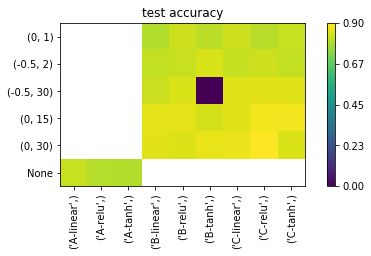

In [23]:
plt.figure(figsize=(8,3))
cax = plt.imshow(r_test.T)
plt.yticks(range(len(r_test.columns)), r_test.columns)
plt.xticks(range(len(r_test.index)), r_test.index, rotation="vertical");
ticks = np.linspace(np.nanmin(r_test.values), np.nanmax(r_test.values), 5)
cbar = plt.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(["%.2f"%i for i in ticks]);    
plt.title("test accuracy");

### Build the bar plots

Text(0, 0.5, 'mean accuracy')

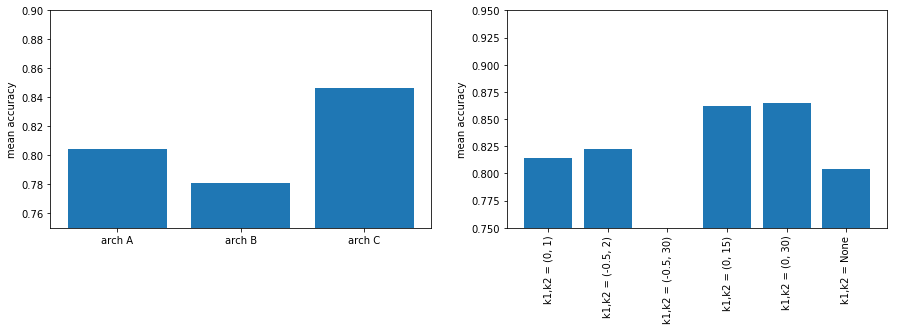

In [24]:
plt.figure(figsize=(15,4))
plt.subplot(121)
r_test["arch"] = [i[0].split("-")[0] for i in r_test.index]
bars = r_test.groupby("arch").mean().T.mean()
plt.bar(range(len(bars)), bars.values)
plt.xticks(range(len(bars)), ["arch %s"%i for i in bars.index])
plt.ylim(.75,.9)
plt.ylabel("mean accuracy")
plt.subplot(122)
bars = r_test.mean()
plt.bar(range(len(bars)), bars.values)
plt.xticks(range(len(bars)), ["k1,k2 = %s"%str(i) for i in bars.index], rotation="vertical")
plt.ylim(.75, .95)
plt.ylabel("mean accuracy")